# Plotting the Functions

In [87]:
import power
from nbodykit.cosmology import Planck15
from vmad import Builder, autooperator, operator
import numpy as np
from nbodykit import cosmology
from matplotlib import pyplot as plt

In [88]:
%matplotlib notebook

In [89]:
z     =  0
k     =  np.linspace(.005, 1.5, 1e5)
cosmo =  Planck15

power_EH, vjp_EH   = power.get_Pk_EH.build(cosmo=cosmo, z=z, k=k).compute_with_vjp(init=dict(Omega0_m=cosmo.Omega0_m), 
                                                                                   v=dict(_Pk=1/cosmo.h)) 
power_NWEH, vjp_NWEH = power.get_Pk_NWEH.build(cosmo=cosmo, z=z, k=k).compute_with_vjp(init=dict(Omega0_m=cosmo.Omega0_m),
                                                                                       v=dict(_Pk=1/cosmo.h)) 

power_NWEH = power_NWEH[0]  * power.normalize(8, cosmo, transfer='NWEH')
power_EH   = power_EH[0]    * power.normalize(8, cosmo, transfer='EH')

In [90]:
cosmo_power_NWEH  =  cosmology.LinearPower(cosmo, z, transfer='NoWiggleEisensteinHu').__call__(k)
cosmo_power_EH    =  cosmology.LinearPower(cosmo, z, transfer='EisensteinHu').__call__(k)
cosmo_power_CLASS =  cosmology.LinearPower(cosmo, z, transfer='CLASS').__call__(k)

<IPython.core.display.Javascript object>


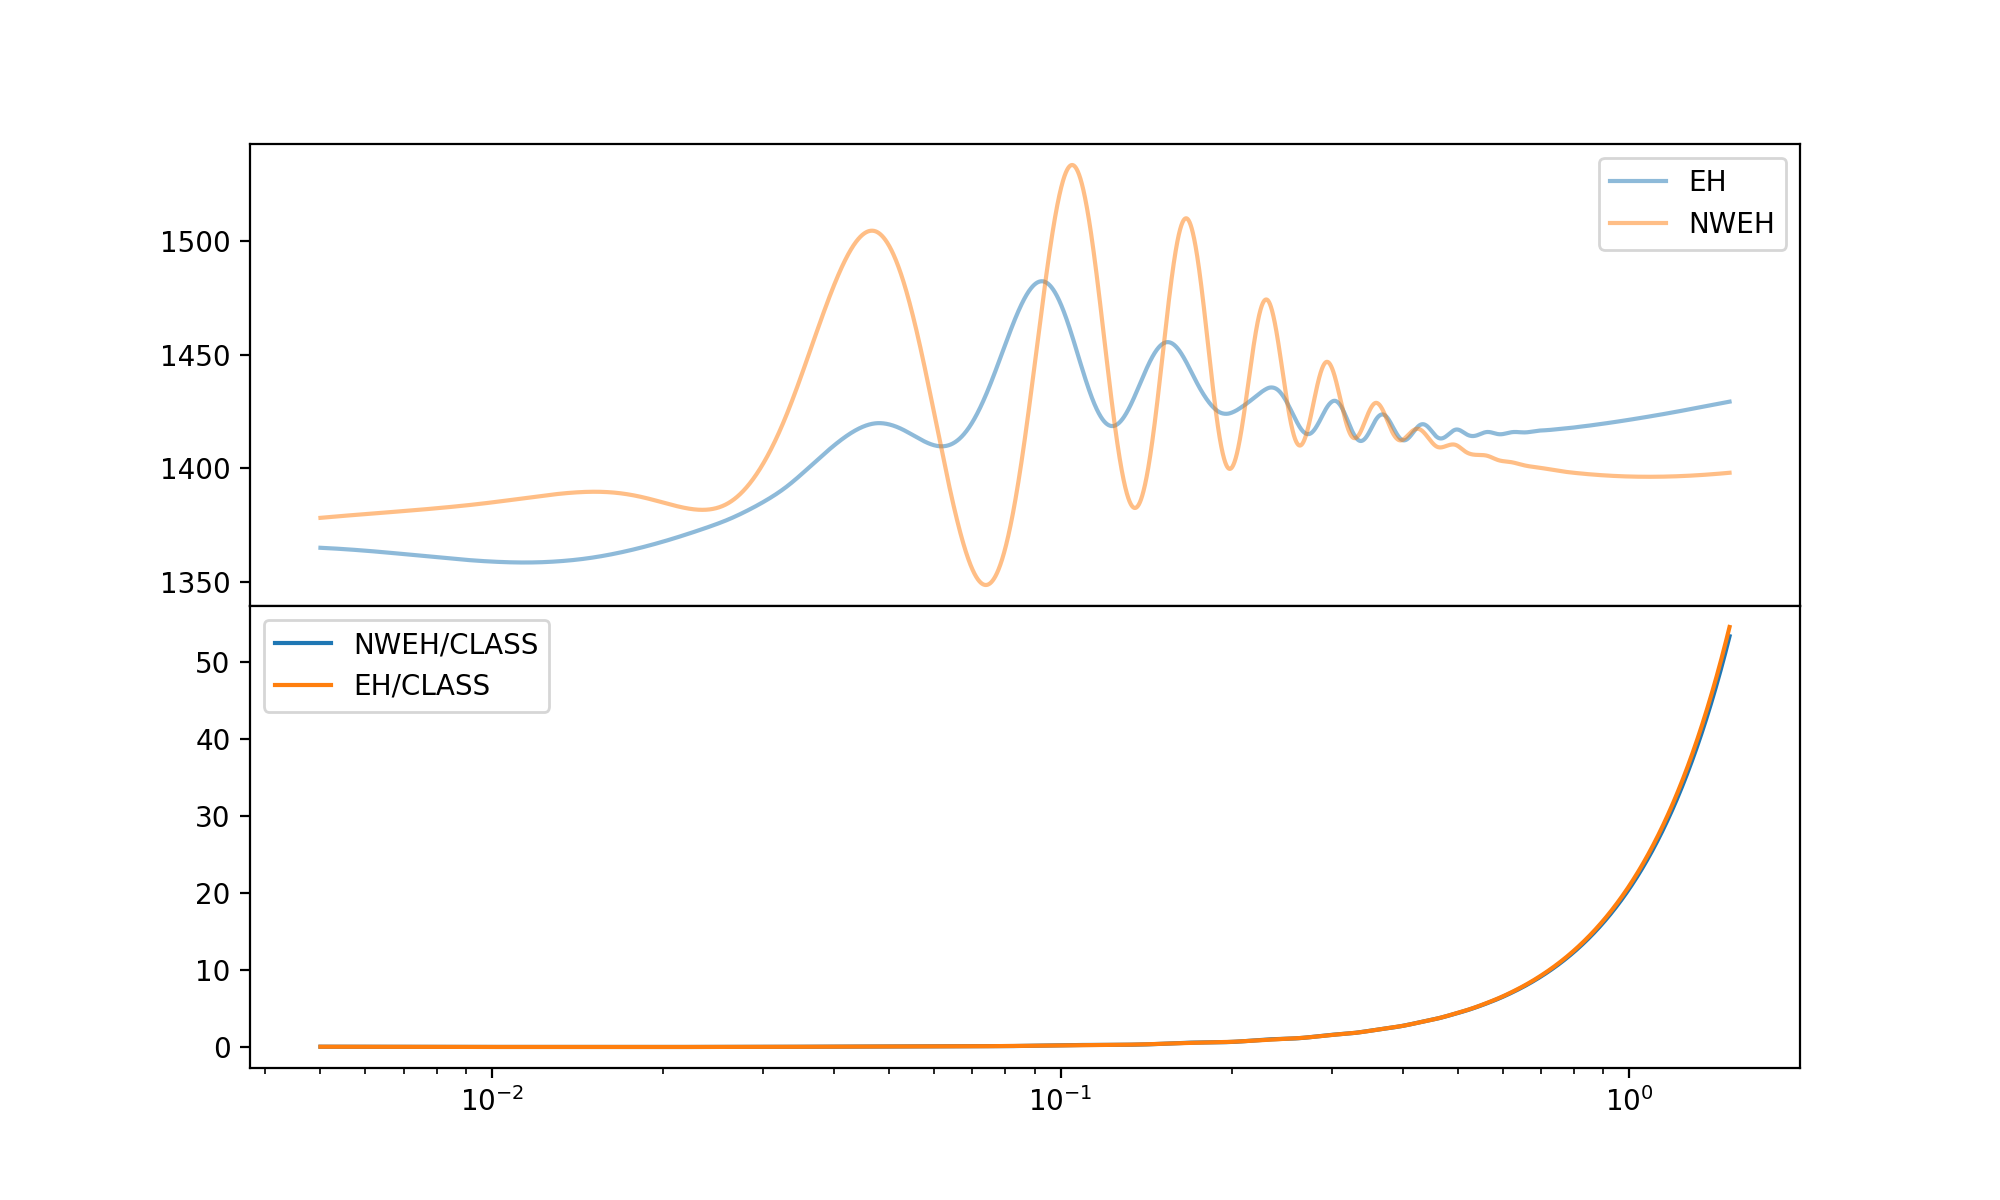

In [91]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace':0}, figsize=(10,6))
# ax1.semilogx(k,cosmo_power_NWEH, label='NWEH max')
# ax1.semilogx(k,cosmo_power_EH, label='EH max')
# ax1.semilogx(k,cosmo_power_CLASS, ':k', label='CLASS', alpha=.8)
ax1.semilogx(k, power_EH, label='EH', alpha=.5)
ax1.semilogx(k, power_NWEH, label='NWEH', alpha=.5)
ax1.legend()

ax2.semilogx(k, power_NWEH/cosmo_power_CLASS, label='NWEH/CLASS')
ax2.semilogx(k, power_EH/cosmo_power_CLASS, label='EH/CLASS')
ax2.legend()

# Power Finite Differencing

In [92]:
class EisensteinHu(object):
    """
    The linear matter transfer function using the Eisenstein & Hu (1998)
    fitting formula with BAO wiggles.

    Parameters
    ----------
    cosmo : :class:`Cosmology`
        the cosmology instance
    redshift : float
        the redshift of the power spectrum

    References
    ----------
    Eisenstein & Hu, "Baryonic Features in the Matter Transfer Function", 1998
    """
    def __init__(self, cosmo, Omega0_m, redshift):

        self.cosmo = cosmo
        self.redshift = redshift

        self.Obh2 = cosmo.Omega0_b * cosmo.h ** 2
        self.Omh2 = Omega0_m * cosmo.h ** 2
        self.f_baryon = cosmo.Omega0_b / Omega0_m
        self.theta_cmb = cosmo.Tcmb0 / 2.7

        # redshift and wavenumber of equality
        self.z_eq = 2.5e4 * self.Omh2 * self.theta_cmb ** (-4) # this is 1 + z
        self.k_eq = 0.0746 * self.Omh2 * self.theta_cmb ** (-2) # units of 1/Mpc

        # sound horizon and k_silk
        self.z_drag_b1 = 0.313 * self.Omh2 ** -0.419 * (1 + 0.607 * self.Omh2 ** 0.674)
        self.z_drag_b2 = 0.38 * self.Omh2 ** 0.223
        self.z_drag    = 1291 * self.Omh2 ** 0.251 / (1. + 0.659 * self.Omh2 ** 0.828) * \
                           (1. + self.z_drag_b1 * self.Obh2 ** self.z_drag_b2)

        self.r_drag = 31.5 * self.Obh2 * self.theta_cmb ** -4 * (1000. / (1+self.z_drag))
        self.r_eq   = 31.5 * self.Obh2 * self.theta_cmb ** -4 * (1000. / self.z_eq)

        self.sound_horizon = 2. / (3.*self.k_eq) * np.sqrt(6. / self.r_eq) * \
                    np.log((np.sqrt(1 + self.r_drag) + np.sqrt(self.r_drag + self.r_eq)) / (1 + np.sqrt(self.r_eq)) )
        self.k_silk = 1.6 * self.Obh2 ** 0.52 * self.Omh2 ** 0.73 * (1 + (10.4*self.Omh2) ** -0.95)

        # alpha_c
        alpha_c_a1 = (46.9*self.Omh2) ** 0.670 * (1 + (32.1*self.Omh2) ** -0.532)
        alpha_c_a2 = (12.0*self.Omh2) ** 0.424 * (1 + (45.0*self.Omh2) ** -0.582)
        self.alpha_c = alpha_c_a1 ** -self.f_baryon * alpha_c_a2 ** (-self.f_baryon**3)

        # beta_c
        beta_c_b1 = 0.944 / (1 + (458*self.Omh2) ** -0.708)
        beta_c_b2 = 0.395 * self.Omh2 ** -0.0266
        self.beta_c = 1. / (1 + beta_c_b1 * ((1-self.f_baryon) ** beta_c_b2) - 1)

        y = self.z_eq / (1 + self.z_drag)
        alpha_b_G = y * (-6.*np.sqrt(1+y) + (2. + 3.*y) * np.log((np.sqrt(1+y)+1) / (np.sqrt(1+y)-1)))
        self.alpha_b = 2.07 *  self.k_eq * self.sound_horizon * (1+self.r_drag)**-0.75 * alpha_b_G

        self.beta_node = 8.41 * self.Omh2 ** 0.435
        self.beta_b    = 0.5 + self.f_baryon + (3. - 2.*self.f_baryon) * np.sqrt( (17.2*self.Omh2) ** 2 + 1 )

    def __call__(self, k, Omega0_m):
        r"""
        Return the Eisenstein-Hu transfer function with BAO wiggles.

        This is normalized to unity as :math:`k \rightarrow 0` at :math:`z=0`.
        The redshift scaling is provided by the
        :func:`Cosmology.scale_independent_growth_factor` function.

        Parameters
        ---------
        k : float, array_like
            the wavenumbers in units of :math:`h \mathrm{Mpc}^{-1}`

        Returns
        -------
        Tk : float, array_like
            the transfer function evaluated at ``k``, normalized to unity on
            large scales
        """

        k = np.asarray(k)
  

        k = k * self.cosmo.h # now in 1/Mpc
        q = k / (13.41*self.k_eq)
        ks = k*self.sound_horizon

        T_c_ln_beta   = np.log(np.e + 1.8*self.beta_c*q)
        T_c_ln_nobeta = np.log(np.e + 1.8*q);
        T_c_C_alpha   = 14.2 / self.alpha_c + 386. / (1 + 69.9 * q ** 1.08)
        T_c_C_noalpha = 14.2 + 386. / (1 + 69.9 * q ** 1.08)

        T_c_f = 1. / (1. + (ks/5.4) ** 4)
        f = lambda a, b : a / (a + b*q**2)
        T_c = T_c_f * f(T_c_ln_beta, T_c_C_noalpha) + (1-T_c_f) * f(T_c_ln_beta, T_c_C_alpha)

        s_tilde = self.sound_horizon * (1 + (self.beta_node/ks)**3) ** (-1./3.)
        ks_tilde = k*s_tilde

        T_b_T0 = f(T_c_ln_nobeta, T_c_C_noalpha)
        T_b_1 = T_b_T0 / (1 + (ks/5.2)**2 )
        T_b_2 = self.alpha_b / (1 + (self.beta_b/ks)**3 ) * np.exp(-(k/self.k_silk) ** 1.4)
        T_b = np.sinc(ks_tilde/np.pi) * (T_b_1 + T_b_2)

        T = self.f_baryon*T_b + (1-self.f_baryon)*T_c;
        return T * growth_rate(Omega0_m, self.redshift)

class NoWiggleEisensteinHu(object):
    """
    Linear power spectrum using the Eisenstein & Hu (1998) fitting formula
    without BAO wiggles.

    Parameters
    ----------
    cosmo : :class:`Cosmology`
        the cosmology instance
    redshift : float
        the redshift of the power spectrum

    References
    ----------
    Eisenstein & Hu, "Baryonic Features in the Matter Transfer Function", 1998
    """
    def __init__(self, cosmo, Omega0_m, redshift):
        self.cosmo = cosmo
        self.redshift = redshift

        self.Obh2      = cosmo.Omega0_b * cosmo.h ** 2
        self.Omh2      = Omega0_m * cosmo.h ** 2
        self.f_baryon  = cosmo.Omega0_b / Omega0_m
        self.theta_cmb = cosmo.Tcmb0 / 2.7

        # wavenumber of equality
        self.k_eq = 0.0746 * self.Omh2 * self.theta_cmb ** (-2) # units of 1/Mpc

        self.sound_horizon = cosmo.h * 44.5 * np.log(9.83/self.Omh2) / \
                            np.sqrt(1 + 10 * self.Obh2** 0.75) # in Mpc/h
        self.alpha_gamma = 1 - 0.328 * np.log(431*self.Omh2) * self.f_baryon + \
                            0.38* np.log(22.3*self.Omh2) * self.f_baryon ** 2


    def __call__(self, k, Omega0_m):
        r"""
        Return the Eisenstein-Hu transfer function without BAO wiggles.

        This is normalized to unity as :math:`k \rightarrow 0` at :math:`z=0`.
        The redshift scaling is provided by the
        :func:`~Cosmology.scale_independent_growth_factor` function.

        Parameters
        ---------
        k : float, array_like
            the wavenumbers in units of :math:`h \mathrm{Mpc}^{-1}`

        Returns
        -------
        Tk : float, array_like
            the transfer function evaluated at ``k``, normalized to unity on
            large scales
        """


        # only compute k > 0 modes
        k = np.asarray(k)

        k = k * self.cosmo.h # in 1/Mpc now
        ks = k * self.sound_horizon / self.cosmo.h
        q = k / (13.41*self.k_eq)

        gamma_eff = self.Omh2 * (self.alpha_gamma + (1 - self.alpha_gamma) / (1 + (0.43*ks) ** 4))
        q_eff = q * self.Omh2 / gamma_eff
        L0 = np.log(2*np.e + 1.8 * q_eff)
        C0 = 14.2 + 731.0 / (1 + 62.5 * q_eff)

        T = L0 / (L0 + C0 * q_eff**2)
        return T * growth_rate(Omega0_m, self.redshift) 

In [93]:
def grow_test(omega_z, omega_lambda, z):
    pre_fac = (1+z)**(-1)* 5* omega_z/ 2
    inside =(omega_z**4/7- omega_lambda+(1+ omega_z/2)*(1+ omega_lambda/70))**(-1)
    return pre_fac* inside

def get_omega_z_test(omega0_m, z):
    omega0_l = 1- omega0_m
    num      =omega0_m* (1+z)**3
    denom    = omega0_l+omega0_m* (1+z)**3
    return num/ denom

def get_omega_lambda_test(omega0_m, z):
    omega0_l = 1- omega0_m
    denom = omega0_l+ omega0_m* (1+z)**3
    return omega0_l/ denom

def growth_rate(omega0_m, z):
    omega_z = get_omega_z_test(omega0_m, z)
    omega_lambda = get_omega_lambda_test(omega0_m, z)
    growth_z = grow_test(omega_z, omega_lambda, z)
    omega_z = get_omega_z_test(omega0_m, 0)
    omega_lambda = get_omega_lambda_test(omega0_m, 0)
    growth_0 = grow_test(omega_z, omega_lambda, 0)
    return growth_z/growth_0

def finite_diff(cosmo, z, k, delta, transfer):
    Omega0_m_2 = cosmo.Omega0_m+delta/2
    Omega0_m_1 = cosmo.Omega0_m-delta/2
    
    
    if transfer == 'EH':
        T_1 = EisensteinHu(cosmo, Omega0_m_1, z).__call__(k, Omega0_m_1)**2 
        T_2 = EisensteinHu(cosmo, Omega0_m_2, z).__call__(k, Omega0_m_2)**2
    elif transfer == 'NWEH':
        T_1 = NoWiggleEisensteinHu(cosmo, Omega0_m_1, z).__call__(k, Omega0_m_1)**2
        T_2 = NoWiggleEisensteinHu(cosmo, Omega0_m_2, z).__call__(k, Omega0_m_2)**2
    else:
        raise ValueError()
    factor = (k/cosmo.h)**cosmo.n_s
    
        
    fiducial_power_1 = cosmology.LinearPower(cosmo, z).__call__(k)
    
    return (T_2-T_1)/delta*factor/fiducial_power_1

In [95]:
delta = cosmo.Omega0_m*1e-3

test_EH = finite_diff(cosmo, z, k, delta, 'EH')
test_NWEH = finite_diff(cosmo, z, k, delta, 'NWEH')

In [99]:
div = vjp_NWEH/test_NWEH
div.mean(), div.std()

(1.0130544878779477, 6.593974571625168e-08)

<IPython.core.display.Javascript object>


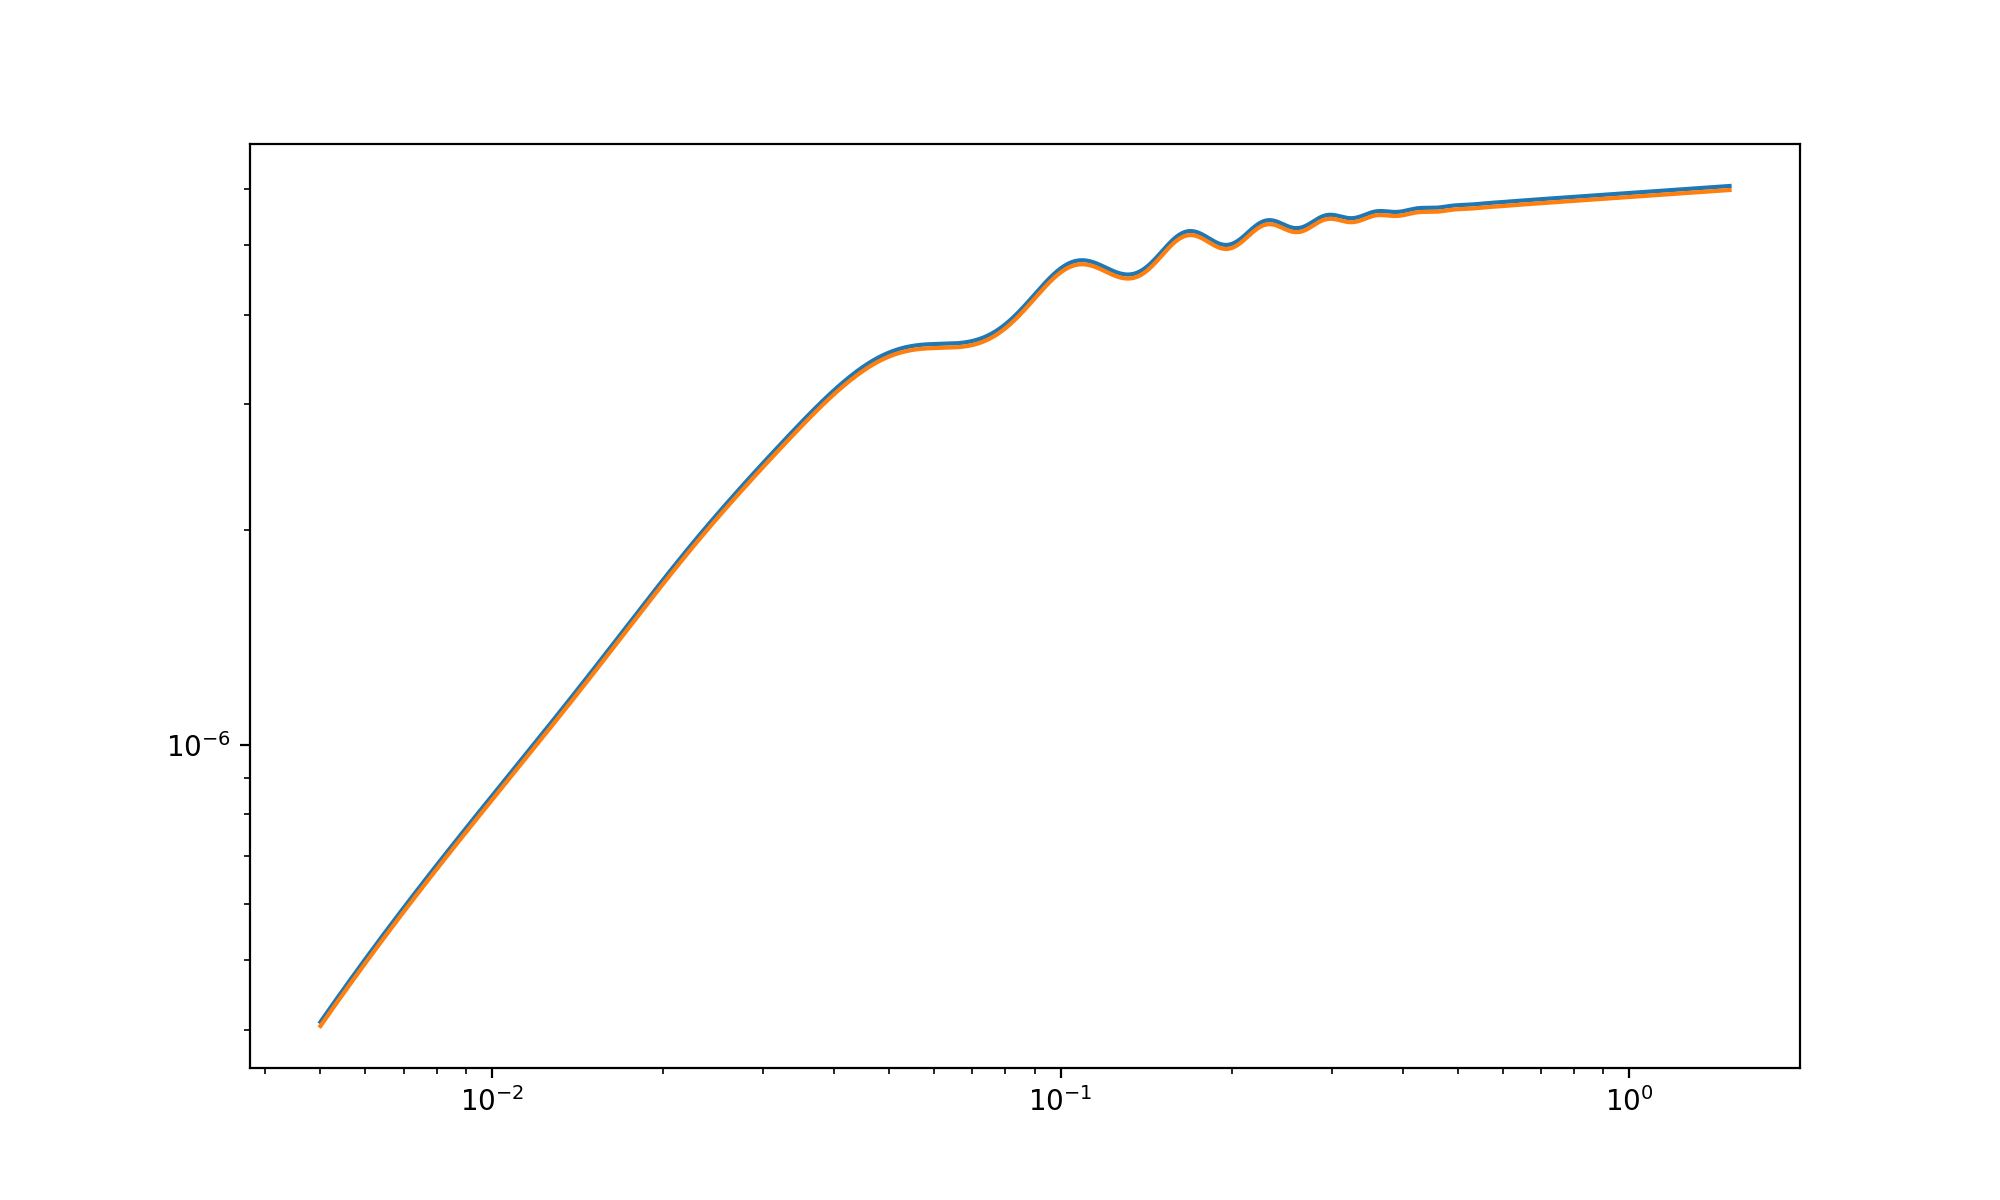

In [101]:
plt.figure(figsize=(10,6))
plt.semilogx(k, vjp_NWEH[0])
plt.loglog(k, test_NWEH)

# Z->chi Finite Differencing

In [17]:
from scipy.integrate import quad

In [62]:
#Max's Operator for matter
@operator
class z_chi_matter:
    ain  = {'omega0_m': 'float', 'z':'float'}
    aout = {'chi':'float'}

    def apl(node, omega0_m, z):
        #Calculate the integral from 0->z
        E         = lambda x: (omega0_m  * ((1+x)**3 -1)+1)**(-1/2)
        Dc , _    = quad(E, 0, z)
        return dict(chi = Dc*cosmo.C/cosmo.H0)
    
    def vjp(node, _chi, omega0_m, z):
        
        #Return the derivative of the integral WR2 omega0_m and mult by _chi
        _omega0_m  =  _chi  *  quad(deriv_integral, 0, z, args=(omega0_m))[0] 
        
        
        #Calculate the derivative of the integral with respect to z i.e. the original function
        _z         =  _chi  * (omega0_m * ((1+z)**3 -1)+1)**(-1/2) 
        
        #Multiply by hubble distance and return
        return dict(_omega0_m = _omega0_m*cosmo.C/cosmo.H0, _z= _z*cosmo.C/cosmo.H0 )
    
    def jvp(node, omega0_m_, z_, omega0_m, z):
        
        #Find derivative with respevct to omega_0 and mult by omega0_m_
        omega0_m_   *= omega0_m_ * quad(deriv_integral, 0, z, args=(omega0_m))[0]
        
        #Do same for z
        z_          *=  (omega0_m * ((1+z)**3 -1) +1)**(-1/2)
        
        #Multiply by hubble distance
        return dict(chi_ = omega0_m_*cosmo.C/cosmo.H0   + z_*cosmo.C/cosmo.H0 )
    
def deriv_integral(x, omega0_m):
    """
    Derivative of the comoving distance with respect to matter density
    
    """
    
    #Create the denominator of the integral
    E = (omega0_m * ((1+x)**3 -1)+ 1)**(-3/2)
    
    diriv_factor = (-1/2) * ((1+x)**3-1)

    return E*diriv_factor

def finite_difference(x, delta):
    """
    Forward differencing model for matter density
    """
    om0 = cosmo.Omega0_m
    denom_1 = ((om0+delta/2)*((1+x)**3-1)+1)**(-1/2)
    denom_2 = ((om0-delta/2)*((1+x)**3-1)+1)**(-1/2)
    const = cosmo.C/(delta*cosmo.H0)
    
    
    return const*(denom_1-denom_2)

In [63]:
@autooperator('Omega0_m, z->chi')
def z_chi(Omega0_m, z):
    f= z_chi_matter(Omega0_m, z)
    return dict(chi=f)

In [71]:
z=np.linspace(0, 11, 1e3)

model_matter = z_chi.build()
chi_matter = []
tape_matter = []
for zi in z:
    chi_matter.append(model_matter.compute(init=dict(Omega0_m =cosmo.Omega0_m , z=zi), 
                                              vout='chi', 
                                              return_tape=False))
    tape_matter.append(model_matter.compute(init=dict(Omega0_m =cosmo.Omega0_m , z=zi), 
                                              vout='chi', 
                                              return_tape=True)[1])
    

In [80]:
delta = 1e-2

vjp_init = dict(_chi = 1)

_Omega0_m = []
for tape in tape_matter:
    vjp_matter = tape.get_vjp()
    _Omega0_m.append(vjp_matter.compute(init=vjp_init, vout='_Omega0_m'))

finite_diff = []
for zi in z:
    finite_diff.append(quad(finite_difference, 0, zi, args = (delta))[0])


<IPython.core.display.Javascript object>


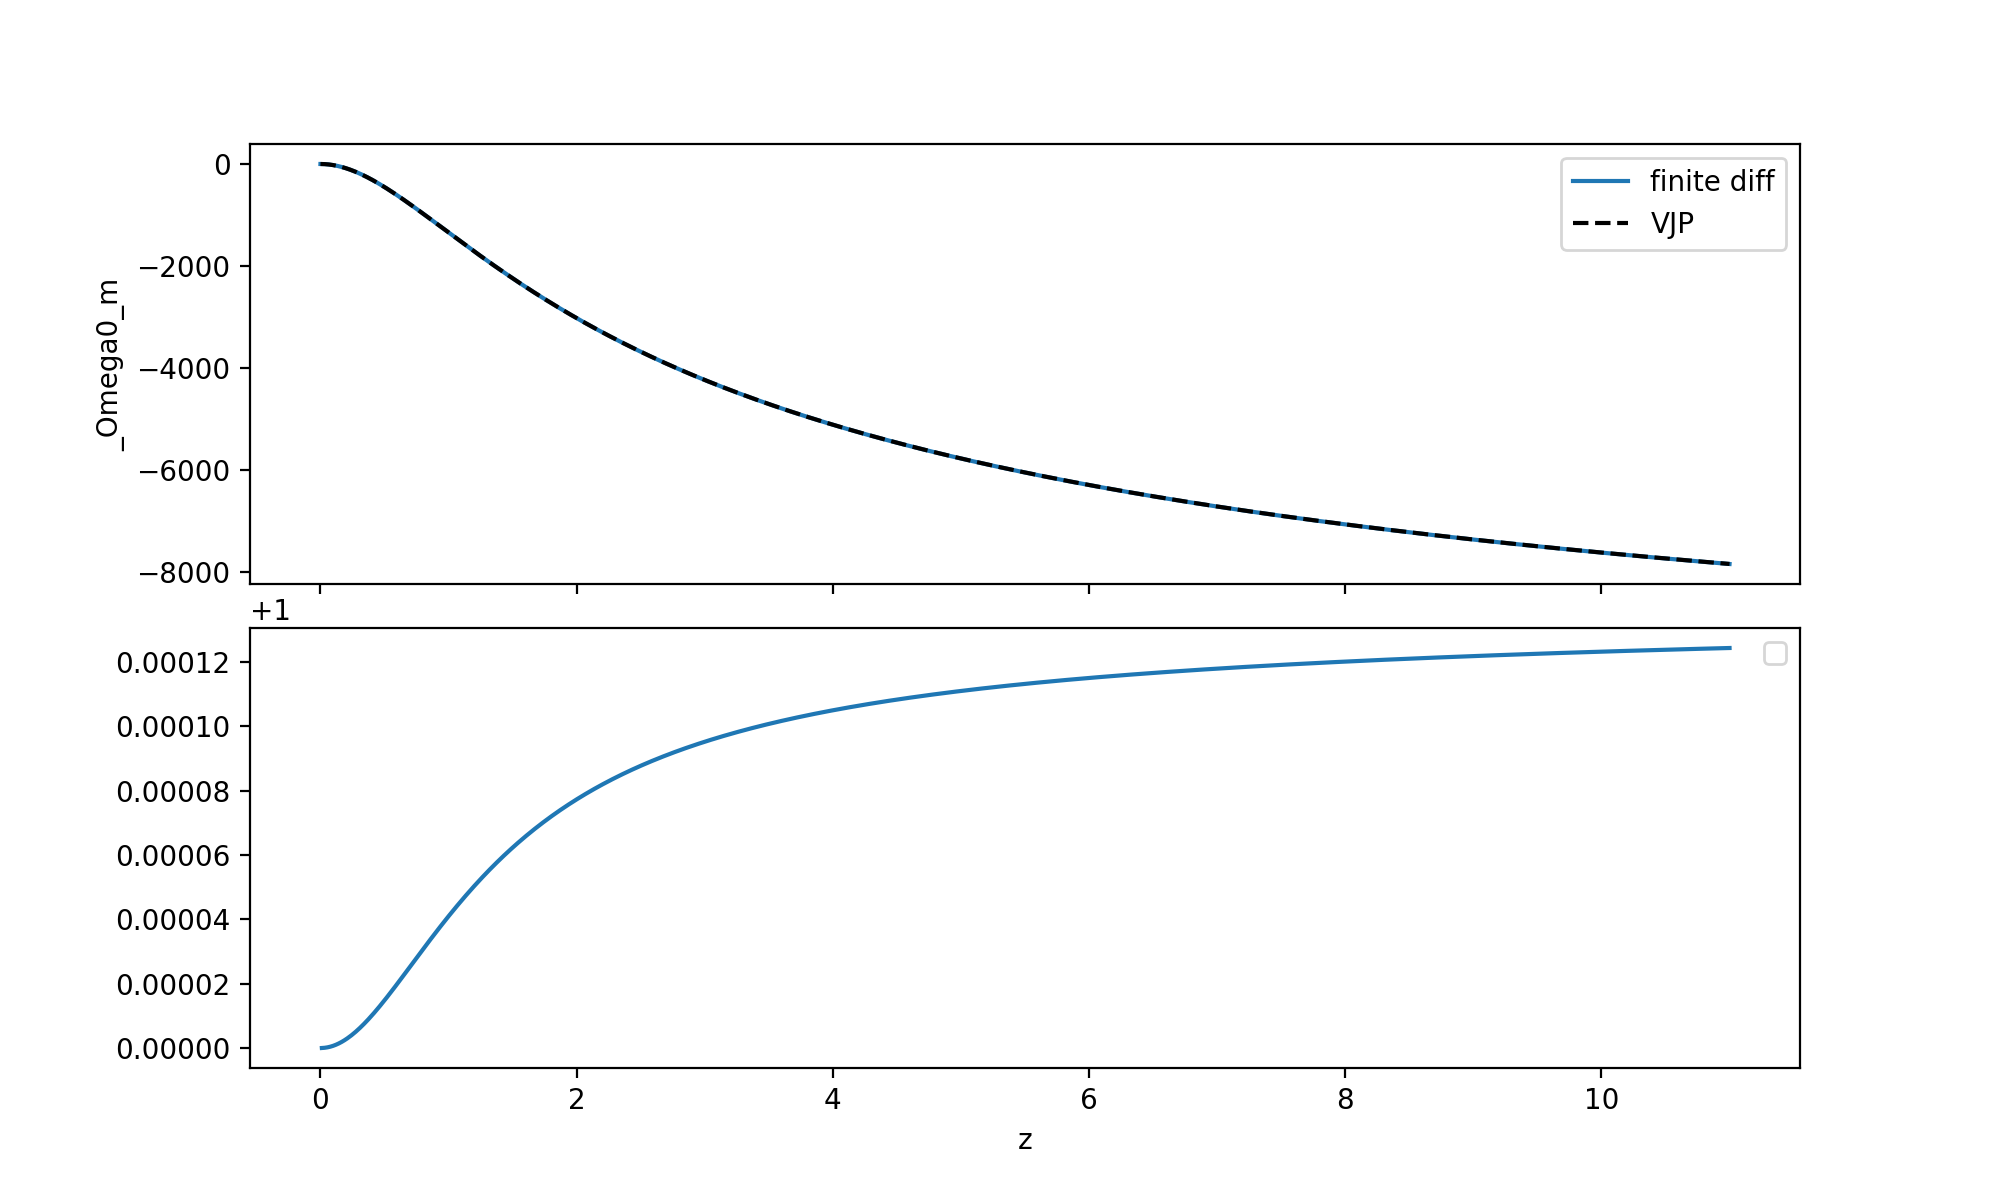

/Users/maxlee/anaconda3/envs/lensing_sim/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
No handles with labels found to put in legend.


In [85]:
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, gridspec_kw={'hspace':.1}, figsize=(10,6))
ax1.plot(z, finite_diff, label='finite diff')
ax1.plot(z, _Omega0_m, '--k', label='VJP')
ax1.legend()
ax1.set_ylabel('_Omega0_m')
ax2.set_xlabel('z')


ax2.plot(z, np.asarray(finite_diff)/np.asarray(_Omega0_m))

plt.legend()